In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import baltic as bt


import math
from math import comb
from math import sqrt

In [ ]:
def create_normalization(value_range, min_val, max_val):
    """
    Creates a normalization function to map values from one range to another.

    Args:
        value_range (tuple): A tuple (old_min, old_max) representing the original value range.
        min_val (float): Minimum value of the target normalization range.
        max_val (float): Maximum value of the target normalization range.

    Returns:
        function: A function that normalizes input values to the [min_val, max_val] range.

    Docstring generated with ChatGPT 4o.
    """
    old_min, old_max = value_range  # The original range of values

    def normalize(x):
        normalized_x = (x - old_min) / (old_max - old_min) * (max_val - min_val) + min_val
        
        # # Debugging prints
        # print(f"x: {x}, old_min: {old_min}, old_max: {old_max}, normalized_x: {normalized_x}")
        
        # Clip values to ensure they stay in the desired range
        return max(min(normalized_x, max_val), min_val)
    
    return normalize

def adjust_bezier_control(p1, p2, k=1, scale_factor=0.2, vert=5):

    """
    Calculates a control point for a Bezier curve between two points with adaptive curvature.
    This function works in the PlateCarree (lat/lon) projection.

    Args:
        p1 (tuple): Coordinates of the first point (x1, y1).
        p2 (tuple): Coordinates of the second point (x2, y2).
        k (float, optional): Scaling constant for curvature adaptation. Defaults to 1.
        scale_factor (float, optional): Legacy parameter, unused. Defaults to 0.2.
        vert (int, optional): Legacy parameter, unused. Defaults to 5.

    Returns:
        tuple: Coordinates of the computed control point (x, y).

    Docstring generated with ChatGPT 4o.
    """
    mid_x, mid_y = (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]

    # Compute control point perpendicular to the line
    # control_x = mid_x - scale_factor * dy
    # control_y = mid_y + scale_factor * dx

    adaptive_scale = k / sqrt(sqrt(abs(dx)))  # Inversely proportional scaling
    
    control_x = mid_x - adaptive_scale * dy
    control_y = mid_y + adaptive_scale * dx
    
    return (control_x, control_y)



def Bezier(control_points, t_start, t_end, num=30):
    """
    Generates a Bezier curve from a list of control points.

    Args:
        control_points (list): List of (x, y) tuples defining the curve's control points.
        t_start (float): Starting value of the curve parameter t.
        t_end (float): Ending value of the curve parameter t.
        num (int, optional): Number of points to generate along the curve. Defaults to 30.

    Returns:
        list: List of (x, y) tuples representing points along the Bezier curve.

    Docstring generated with ChatGPT 4o.
    """
    t = np.linspace(t_start, t_end, num)
    n = len(control_points) - 1
    curve_points = []
    for t_val in t:
        point = np.array([0.0, 0.0])
        for i, p in enumerate(control_points):
            bernstein_poly = comb(n, i) * (t_val**i) * ((1 - t_val)**(n - i))
            point += bernstein_poly * np.array(p)
        curve_points.append(tuple(point))
    return curve_points

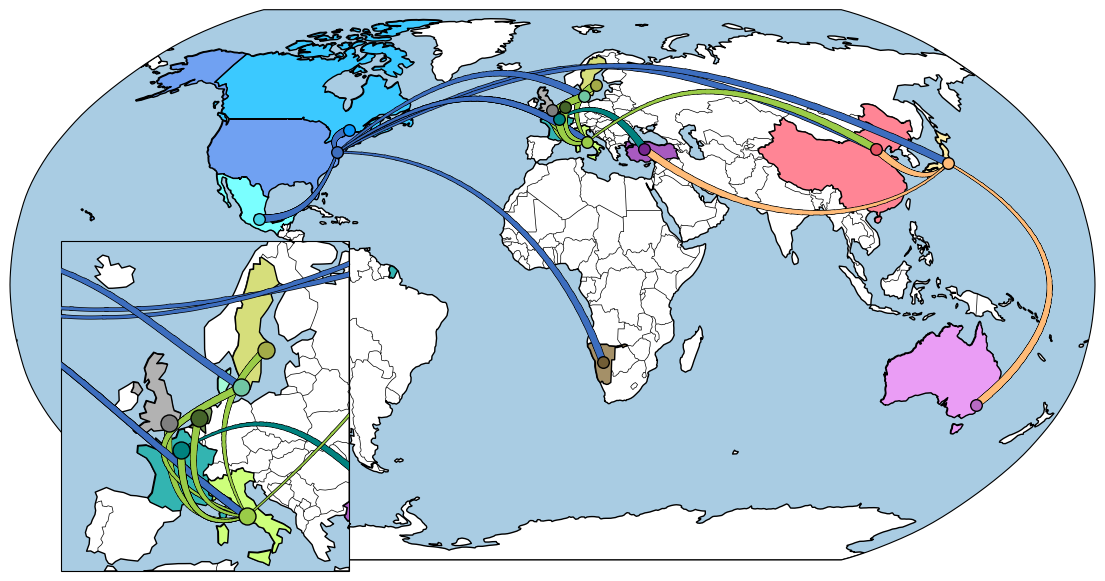

In [3]:
# Define colors
state_color = {
    'United States of America': '#3D6EBF',
    'USA': '#3D6EBF',
    'Canada': '#0896f9',
    'Mexico': "#47d0e4",
    'Netherlands': '#446429',
    'France': '#00817E',
    'Italy': '#9acc48',
    'Denmark': '#70c6a3',
    'Sweden': '#a3ab48',
    'United Kingdom': '#7f7f7f',
    'United_Kingdom': '#7f7f7f',
    'Namibia': '#715d35',
    'China': '#E45262',
    'Japan': '#ffbb78',
    'Turkey': '#75278D',
    'Australia': '#B76AC2'
}

# Modify state color dict for consistent names
state_color2 = state_color.copy()
state_color2["USA"] = state_color2.pop('United States of America')
state_color2["United_Kingdom"] = state_color2.pop('United Kingdom')



# Define the list of countries to highlight
highlighted_countries = [
    'China', 'Turkey', 'Sweden', 'France', 'United States of America', 'Japan', 'Italy', 'Netherlands',
    'Denmark', 'Namibia', 'Canada', 'United Kingdom', 'Mexico', 'Australia'
]

# Load Nexus tree file
treefile = "C:/Users/iblag/Documents/flud/segment4_final.MCC.tree"
ll = bt.loadNexus(treefile, tip_regex=r'(\d{4}-\d{2}(?:-\d{2})?)$')

traitName = 'state'

# Filter travel lineages (lineages traveling)
travel_lineages = sorted([k for k in ll.Objects if k != ll.root and k.parent != ll.root and k.traits[traitName] != k.parent.traits[traitName]], 
                         key=lambda x: x.absoluteTime)

# Define map colors
highlight_color = 'blue'
default_land = 'white'
water = '#A9CCE3'


# Load shapefiles
shp_countries = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader_countries = shpreader.Reader(shp_countries)
countries = list(reader_countries.records())

shp_capitals = shpreader.natural_earth(resolution='110m', category='cultural', name='populated_places')
reader_capitals = shpreader.Reader(shp_capitals)
capitals = list(reader_capitals.records())

# Capital coordinates
capital_coordinates = {}
for capital in capitals:
    country_name = capital.attributes['ADM0NAME']
    if country_name in highlighted_countries and capital.attributes['FEATURECLA'] == 'Admin-0 capital':
        lat = capital.geometry.y
        lon = capital.geometry.x
        dot_color = state_color.get(country_name, 'red')
        capital_coordinates[country_name] = [lat, lon]

# Fix names
if 'United States of America' in capital_coordinates:
    capital_coordinates['USA'] = capital_coordinates.pop('United States of America')
if 'United Kingdom' in capital_coordinates:
    capital_coordinates['United_Kingdom'] = capital_coordinates.pop('United Kingdom')

# Time normalization
xDates = ['%d-%02d-01' % (year, month) for year in range(1996, 2025) for month in range(1, 13)]
height_normalization = create_normalization([bt.decimalDate(xDates[0]), bt.decimalDate(xDates[-1])], 0.0, 1.0)

# ---- Main Figure with Robinson projection ----
fig, ax = plt.subplots(figsize=(14, 14), facecolor='w', 
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=0)})

# Base world map
ax.set_global()
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=default_land, edgecolor='black', zorder=1)
ax.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor=water, edgecolor=water, zorder=0)
ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='black', linewidth=0.5, zorder=2)

# Highlight countries
for country in countries:
    name = country.attributes['ADMIN']
    if name in highlighted_countries:
        ax.add_geometries(
            [country.geometry], ccrs.PlateCarree(),
            facecolor=mcolors.to_hex([min(1, c + 0.2) for c in mcolors.to_rgb(state_color[name])]), edgecolor='black',
            linewidth=1, zorder=3
        )

# Plot capitals on world map
for country_name, (lat, lon) in capital_coordinates.items():
    dot_color = state_color.get(country_name, 'red')
    ax.scatter(lon, lat, color=dot_color, marker='o', s=70, edgecolor='black',
               transform=ccrs.PlateCarree(), zorder=300)

# Plot arcs on world map
for k in travel_lineages:
    locA = k.traits[traitName]
    locB = k.parent.traits[traitName]

    if locA not in capital_coordinates or locB not in capital_coordinates:
        continue

    oriY, oriX = capital_coordinates[locB]
    desY, desX = capital_coordinates[locA]

    normalized_height = height_normalization(k.absoluteTime)
    distance = math.sqrt((oriX - desX)**2 + (oriY - desY)**2)
    control = adjust_bezier_control((oriX, oriY), (desX, desY), scale_factor=0.3)
    curve = Bezier([(oriX, oriY), control, (desX, desY)], 0.0, 1.0, num=30)

    for i in range(len(curve) - 1):
        x1, y1 = curve[i]
        x2, y2 = curve[i + 1]
        frac = i / float(len(curve))
        lw = 1 + 4 * frac
        outline = 2 + 4 * frac
        ax.plot([x1, x2], [y1, y2], lw=lw, color=state_color2[locB],
                transform=ccrs.PlateCarree(), zorder=200 * normalized_height)
        ax.plot([x1, x2], [y1, y2], lw=outline, color="black",
                transform=ccrs.PlateCarree(), zorder=200 * normalized_height - 0.5)

# ---- Inset with EuroPP projection ----

ax2 = ax.inset_axes([-0.12, -0.02, 0.6, 0.6], projection=ccrs.EuroPP())

# Base Europe map
ax2.set_global()
ax2.add_feature(cfeature.LAND.with_scale('110m'), facecolor=default_land, edgecolor='black', zorder=1)
ax2.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor=water, edgecolor=water, zorder=0)
ax2.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='black', linewidth=0.5, zorder=2)

# Highlight countries in Europe inset
for country in countries:
    name = country.attributes['ADMIN']
    if name in highlighted_countries:
        ax2.add_geometries(
            [country.geometry], ccrs.PlateCarree(),
            facecolor=mcolors.to_hex([min(1, c + 0.2) for c in mcolors.to_rgb(state_color[name])]), edgecolor='black',
            linewidth=1, zorder=3
        )

# Plot capitals in Europe inset
for country_name, (lat, lon) in capital_coordinates.items():
    dot_color = state_color.get(country_name, 'red')
    ax2.scatter(lon, lat, color=dot_color, marker='o', s=150, edgecolor='black',
                transform=ccrs.PlateCarree(), zorder=300)

# Plot arcs in Europe inset
for k in travel_lineages:
    locA = k.traits[traitName]
    locB = k.parent.traits[traitName]

    if locA not in capital_coordinates or locB not in capital_coordinates:
        continue

    oriY, oriX = capital_coordinates[locB]
    desY, desX = capital_coordinates[locA]

    normalized_height = height_normalization(k.absoluteTime)
    distance = math.sqrt((oriX - desX)**2 + (oriY - desY)**2)
    control = adjust_bezier_control((oriX, oriY), (desX, desY), scale_factor=0.3)
    curve = Bezier([(oriX, oriY), control, (desX, desY)], 0.0, 1.0, num=30)

    for i in range(len(curve) - 1):
        x1, y1 = curve[i]
        x2, y2 = curve[i + 1]
        frac = i / float(len(curve))
        lw = 1 + 4 * frac
        outline = 2 + 4 * frac
        ax2.plot([x1, x2], [y1, y2], lw=lw, color=state_color2[locB],
                 transform=ccrs.PlateCarree(), zorder=200 * normalized_height)
        ax2.plot([x1, x2], [y1, y2], lw=outline, color="black",
                 transform=ccrs.PlateCarree(), zorder=200 * normalized_height - 0.5)

plt.show()
ries = shpreader.Reader(shp_countries)
countries = list(reader_countries.records())

shp_capitals = shpreader.natural_earth(resolution='110m', category='cultural', name='populated_places')
reader_capitals = shpreader.Reader(shp_capitals)
capitals = list(reader_capitals.records())

# Create capital_coordinates only once
capital_coordinates = {}
for capital in capitals:
    country_name = capital.attributes['ADM0NAME']
    if country_name in highlighted_countries and capital.attributes['FEATURECLA'] == 'Admin-0 capital':
        lat = capital.geometry.y
        lon = capital.geometry.x
        dot_color = state_color.get(country_name, 'red')
        capital_coordinates[country_name] = [lat, lon]

# Name fix
if 'United States of America' in capital_coordinates:
    capital_coordinates['USA'] = capital_coordinates.pop('United States of America')
if 'United Kingdom' in capital_coordinates:
    capital_coordinates['United_Kingdom'] = capital_coordinates.pop('United Kingdom')

# Time normalization
xDates = ['%d-%02d-01' % (year, month) for year in range(1996, 2025) for month in range(1, 13)]
height_normalization = create_normalization([bt.decimalDate(xDates[0]), bt.decimalDate(xDates[-1])], 0.0, 1.0)

def plot_map(ax, projection, show_arcs=True):
    # Base map
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=default_land, edgecolor='black', zorder=1)
    ax.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor=water, edgecolor=water, zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='black', linewidth=0.5, zorder=2)

    # Highlight countries
    for country in countries:
        name = country.attributes['ADMIN']
        if name in highlighted_countries:
            ax.add_geometries(
                [country.geometry], ccrs.PlateCarree(),
                facecolor=mcolors.to_hex([min(1, c + 0.2) for c in mcolors.to_rgb(state_color[name])]),
                edgecolor='black', linewidth=1, zorder=3
            )

    # Plot capitals
    for country_name, (lat, lon) in capital_coordinates.items():
        dot_color = state_color.get(country_name, 'red')
        ax.scatter(lon, lat, color=dot_color, marker='o', s=100, edgecolor='black',
                   transform=ccrs.PlateCarree(), zorder=300)

    # Plot arcs
    if show_arcs:
        for k in travel_lineages:
            locA = k.traits[traitName]
            locB = k.parent.traits[traitName]

            if locA not in capital_coordinates or locB not in capital_coordinates:
                continue

            oriY, oriX = capital_coordinates[locB]
            desY, desX = capital_coordinates[locA]

            normalized_height = height_normalization(k.absoluteTime)

            distance = math.sqrt((oriX - desX)**2 + (oriY - desY)**2)
            control = adjust_bezier_control((oriX, oriY), (desX, desY), scale_factor=0.3)
            curve = Bezier([(oriX, oriY), control, (desX, desY)], 0.0, 1.0, num=30)

            for i in range(len(curve) - 1):
                x1, y1 = curve[i]
                x2, y2 = curve[i + 1]
                frac = i / float(len(curve))
                lw = 1 + 4 * frac
                outline = 2 + 4 * frac
                ax.plot([x1, x2], [y1, y2], lw=lw, color=state_color2[locB], alpha=0.7,
                        transform=ccrs.PlateCarree(), zorder=200 * normalized_height)
                ax.plot([x1, x2], [y1, y2], lw=outline, color="black",
                        transform=ccrs.PlateCarree(), zorder=200 * normalized_height - 0.5)



plt.show()
